In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
import utils

In [2]:
train_pairs, val_pairs, test_pairs = utils.split_dataset(utils.create_list())

In [5]:
print(f"Number of training pairs: {len(train_pairs)}")
print(f"Number of val pairs: {len(val_pairs)}")
print(f"Number of test_pairs pairs: {len(test_pairs)}")

Number of training pairs: 388
Number of val pairs: 129
Number of test_pairs pairs: 130


In [6]:
train_dataset = utils.create_dataset(train_pairs)
val_dataset = utils.create_dataset(val_pairs)
test_dataset = utils.create_dataset(test_pairs)

Training Dataset:
  Image - min: 0.0, max: 1.0
  Mask  - min: 0.0, max: 1.0



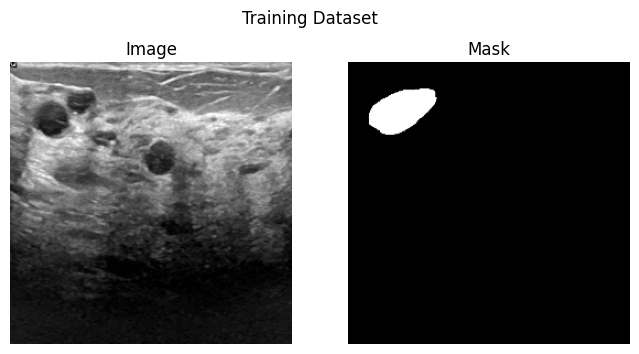

Validation Dataset:
  Image - min: 0.0, max: 0.8867174983024597
  Mask  - min: 0.0, max: 1.0



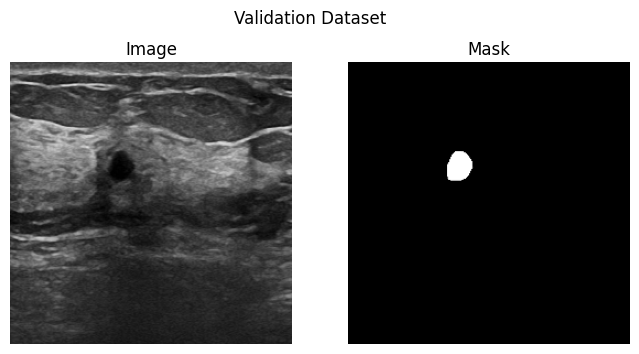

Testing Dataset:
  Image - min: 0.0, max: 1.0
  Mask  - min: 0.0, max: 1.0



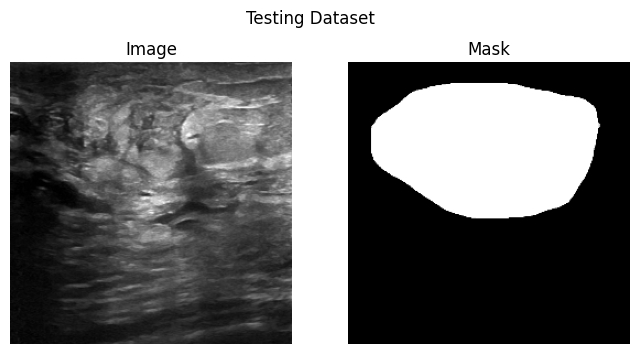

In [8]:
#check if data are correctly normalized and pairs are correctly matched
def show_image_mask(dataset, title):
    #take the first pair from the dataset
    for image, mask in dataset.take(1):
        #convert TensorFlow tensors to NumPy arrays
        image = image.numpy().squeeze()
        mask = mask.numpy().squeeze()

        image_min, image_max = np.min(image), np.max(image)
        mask_min, mask_max = np.min(mask), np.max(mask)

        print(f"{title}:")
        print(f"  Image - min: {image_min}, max: {image_max}")
        print(f"  Mask  - min: {mask_min}, max: {mask_max}")
        print()

        plt.figure(figsize=(8, 4))
        plt.suptitle(title)

        plt.subplot(1, 2, 1)
        plt.title("Image")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.show()
        break

# Display for training, validation, and testing datasets
show_image_mask(train_dataset, "Training Dataset")
show_image_mask(val_dataset, "Validation Dataset")
show_image_mask(test_dataset, "Testing Dataset")

In [9]:
#batch the dataset and shuffle the training set
batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=len(train_pairs)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)